In [ ]:
!pip install "etna[all]@git+https://github.com/etna-team/etna.git@master"
!pip install sktime

  Cloning https://github.com/etna-team/etna.git (to revision master) to /tmp/pip-install-lp2q9hby/etna_e6cf3285fdbf41d68d4bee402fd5efbc
  Running command git clone --filter=blob:none --quiet https://github.com/etna-team/etna.git /tmp/pip-install-lp2q9hby/etna_e6cf3285fdbf41d68d4bee402fd5efbc
  Resolved https://github.com/etna-team/etna.git to commit 9cb5b3814489f4759ab68e62fc384ab248444a05
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import pandas as pd
from etna.datasets.tsdataset import TSDataset
import seaborn as sns
import matplotlib.pyplot as plt

from etna.models.nn import RNNModel
from etna.pipeline import Pipeline
from etna.models import CatBoostMultiSegmentModel, NaiveModel
from etna.metrics import MAE, MSE, SMAPE, MAPE
from etna.transforms import (LagTransform, MeanTransform, DifferencingTransform,
FourierTransform, LinearTrendTransform, LogTransform, STLTransform)

from etna.pipeline import Pipeline
import warnings

from ruptures.detection import Binseg
from etna.analysis import plot_forecast
from etna.analysis import (plot_backtest, acf_plot, cross_corr_plot, plot_trend, get_anomalies_median,
plot_periodogram, get_anomalies_density, find_change_points, plot_time_series_with_change_points, plot_anomalies)


In [ ]:
target_df = pd.read_csv('ETHUSDT_1d.csv', delimiter=',')
regressor_df = pd.read_csv('BTCUSDT_1d.csv', delimiter=',')
# добавляем новый признак (разница между макс и мин ценой за день)
regressor_df['diff_ETH'] = target_df['high'] - target_df['low']
regressor_df = regressor_df.rename(columns={
    'open': 'open_BTC',
    'high': 'high_BTC',
    'low': 'low_BTC',
    'close': 'close_BTC',
    'volume': 'volume_BTC'
})
regressor_df['volume_ETH'] = target_df['volume']
target_df = target_df.drop('volume', axis=1)
# делаем лаги
for i in regressor_df.columns:
  if i != 'timestamp':
    regressor_df[f'lag_2_{i}'] = regressor_df[i].shift(2)
    regressor_df[f'{i}'] = regressor_df[i].shift(1)
target_df = target_df.loc[2:]
# делаем сегменты
segments = []
for feature in ['open', 'high', 'low', 'close']:
    temp = target_df[['timestamp', feature]].copy()
    temp['segment'] = f'main_{feature}'
    temp = temp.rename(columns={feature: 'target'})
    segments.append(temp)
target_df = pd.concat(segments)
# Оставляем место для прогноза на 20 дней
last_date = target_df['timestamp'].max()
cutoff_date = pd.to_datetime(last_date) - pd.Timedelta(days=20)
target_df = target_df[pd.to_datetime(target_df['timestamp']) <= cutoff_date]
# Оставляем только нужные колонки
regressor_df = regressor_df[['timestamp'] + [col for col in regressor_df.columns if col not in ['timestamp', 'segment']]]
# Дублируем регрессоры для всех сегментов
segments_list = target_df['segment'].unique()
regressor_list = []
for segment in segments_list:
    temp = regressor_df.copy()
    temp['segment'] = segment
    regressor_list.append(temp)

regressor_df = pd.concat(regressor_list)
ts = TSDataset(df=target_df, freq="D", df_exog=regressor_df, known_future="all")
print("Сегменты:", ts.segments)
print()
display(ts)


Сегменты: ['main_close', 'main_high', 'main_low', 'main_open']



segment    main_close                                                    \
feature     close_BTC diff_ETH  high_BTC lag_2_close_BTC lag_2_diff_ETH   
timestamp                                                                 
2017-08-19    4108.37    27.85   4371.52         4285.08          14.18   
2017-08-20    4139.98    21.90   4184.69         4108.37          27.85   
2017-08-21    4086.29    17.68   4211.08         4139.98          21.90   
2017-08-22    4016.00    51.92   4119.62         4086.29          17.68   
2017-08-23    4040.00   186.20   4104.82         4016.00          51.92   
...               ...      ...       ...             ...            ...   
2025-02-18   95780.00   211.99  97046.59        96118.12          76.05   
2025-02-19   95671.74   151.49  96753.91        95780.00         211.99   
2025-02-20   96644.37    80.67  96899.99        95671.74         151.49   
2025-02-21   98305.00    63.41  98711.36        96644.37          80.67   
2025-02-22   96181.98   228.60  99475.00        98305.00          63.41   

segment                                                                  \
feature    lag_2_high_BTC lag_2_low_BTC lag_2_open_BTC lag_2_volume_BTC   
timestamp                                                                 
2017-08-19        4485.39       4200.74        4261.48       795.150377   
2017-08-20        4371.52       3938.77        4285.08      1199.888264   
2017-08-21        4184.69       3850.00        4108.37       381.309763   
2017-08-22        4211.08       4032.62        4120.98       467.083022   
2017-08-23        4119.62       3911.79        4069.13       691.743060   
...                   ...           ...            ...              ...   
2025-02-18       97704.47      96046.18       97569.67      8191.424900   
2025-02-19       97046.59      95205.00       96118.12     16492.045100   
2025-02-20       96753.91      93388.09       95780.01     23368.194710   
2025-02-21       96899.99      95029.99       95671.74     16438.509540   
2025-02-22       98711.36      96415.09       96644.37     17057.391770   

segment                      ...      main_open                               \
feature    lag_2_volume_ETH  ... lag_2_high_BTC lag_2_low_BTC lag_2_open_BTC   
timestamp                    ...                                               
2017-08-19       7030.71034  ...        4485.39       4200.74        4261.48   
2017-08-20       9537.84646  ...        4371.52       3938.77        4285.08   
2017-08-21       2146.19773  ...        4184.69       3850.00        4108.37   
2017-08-22       2510.13871  ...        4211.08       4032.62        4120.98   
2017-08-23       5219.44542  ...        4119.62       3911.79        4069.13   
...                     ...  ...            ...           ...            ...   
2025-02-18     191231.53140  ...       97704.47      96046.18       97569.67   
2025-02-19     639739.81970  ...       97046.59      95205.00       96118.12   
2025-02-20     604863.87370  ...       96753.91      93388.09       95780.01   
2025-02-21     326154.02020  ...       96899.99      95029.99       95671.74   
2025-02-22     336735.25440  ...       98711.36      96415.09       96644.37   

segment                                                                    \
feature    lag_2_volume_BTC lag_2_volume_ETH   low_BTC  open_BTC   target   
timestamp                                                                   
2017-08-19       795.150377       7030.71034   3938.77   4285.08   293.31   
2017-08-20      1199.888264       9537.84646   3850.00   4108.37   289.41   
2017-08-21       381.309763       2146.19773   4032.62   4120.98   299.10   
2017-08-22       467.083022       2510.13871   3911.79   4069.13   321.04   
2017-08-23       691.743060       5219.44542   3400.00   4016.00   312.25   
...                     ...              ...       ...       ...      ...   
2025-02-18      8191.424900     191231.53140  95205.00  96118.12  2744.05   
2025-02

Таргеты


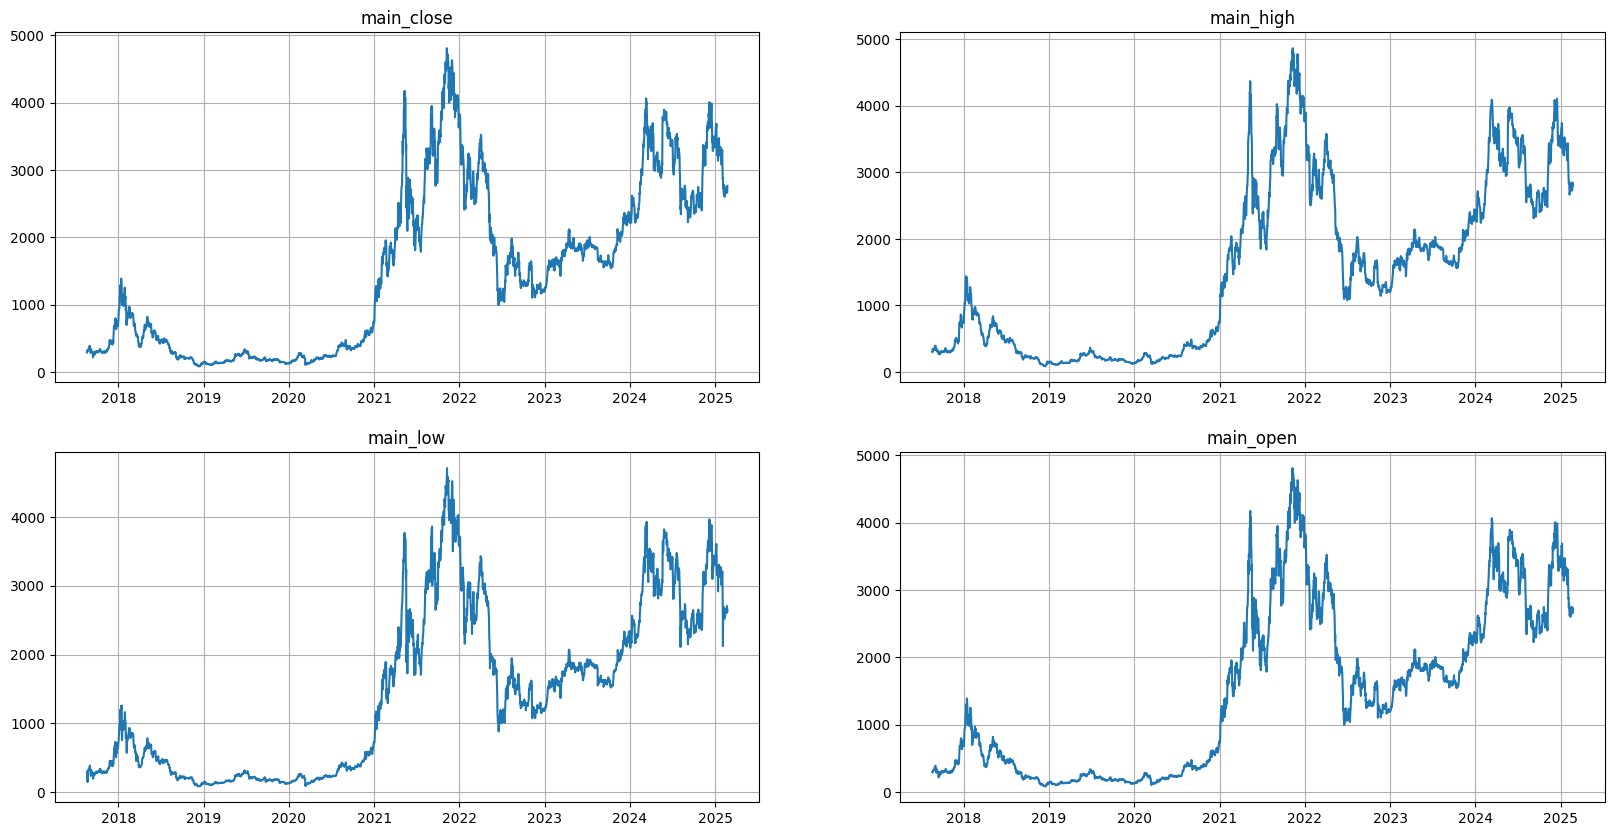

In [ ]:
print('Таргеты')
ts.plot(column="target", n_segments=5)

Регрессоры


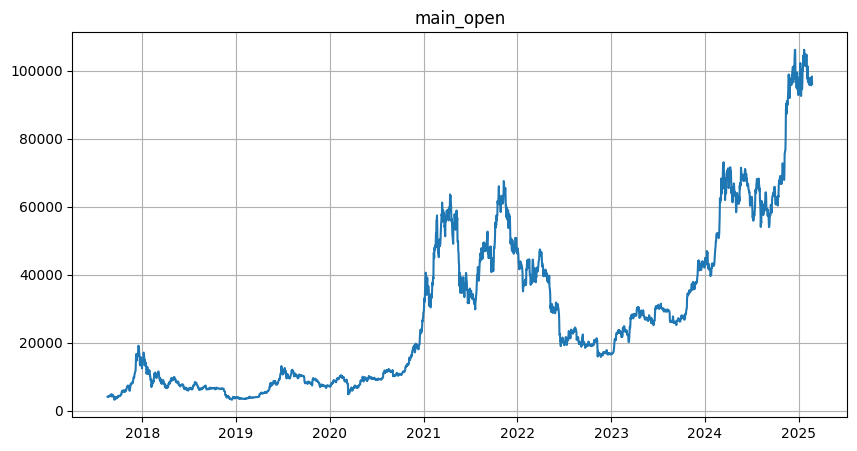

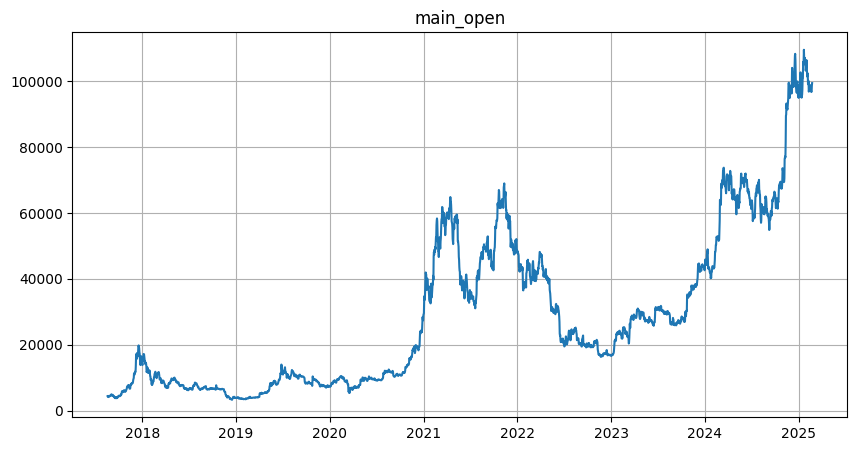

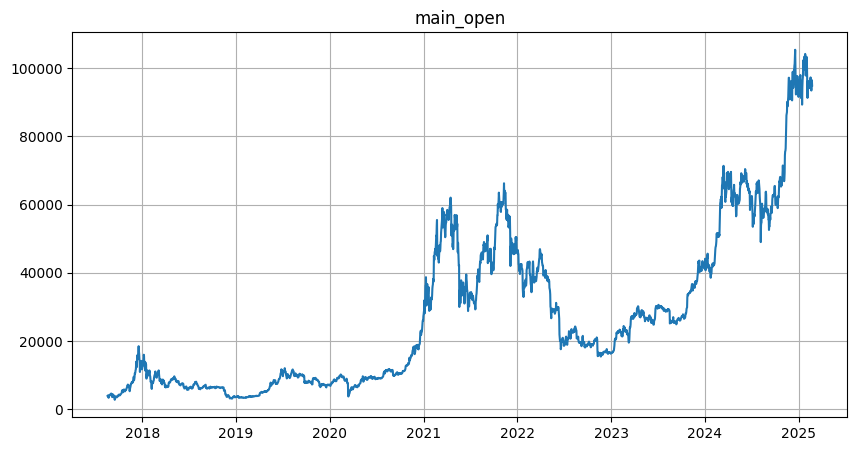

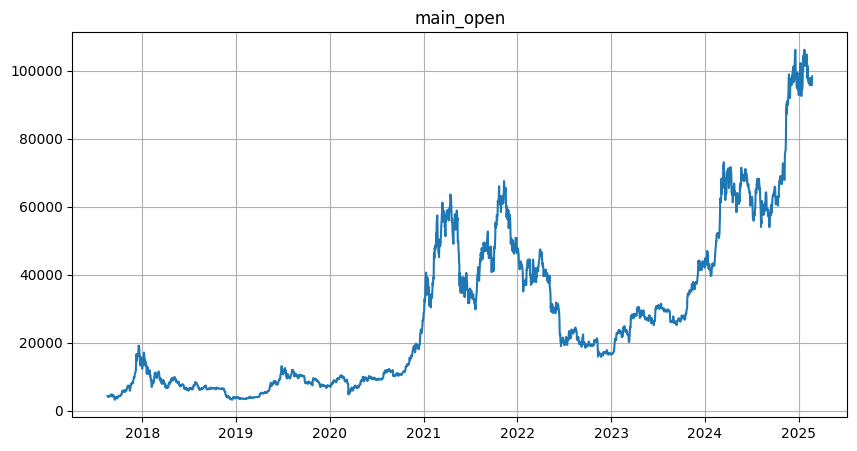

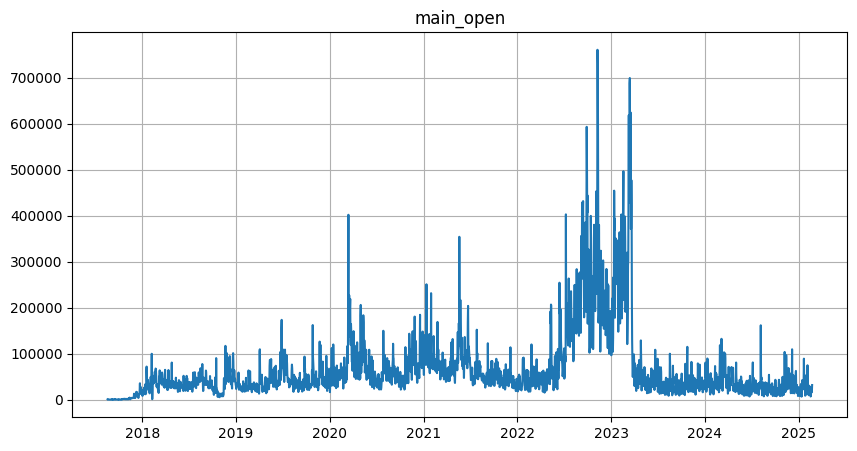

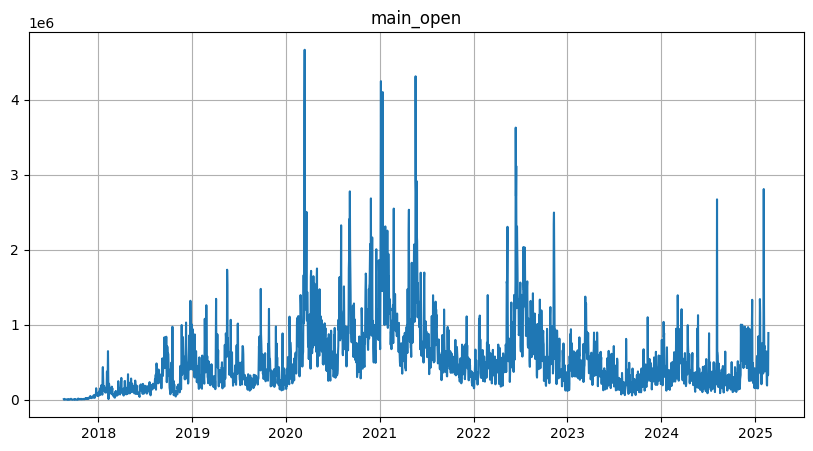

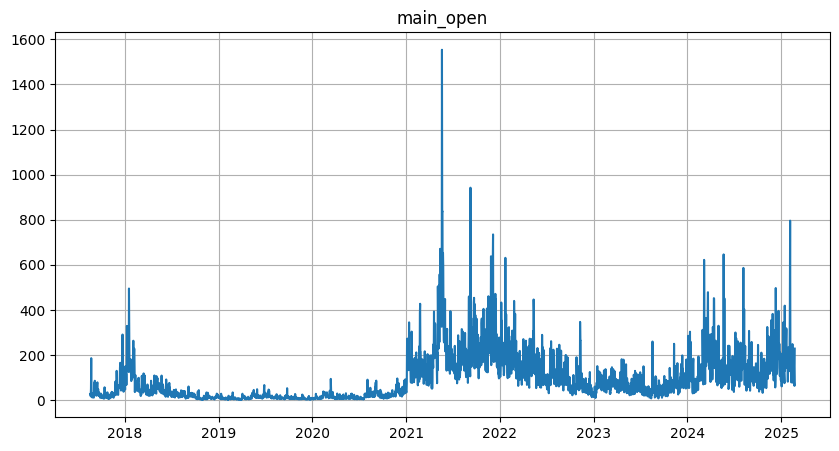

In [ ]:
print('Регрессоры')
ts.plot(column="close_BTC", n_segments=1)
ts.plot(column="high_BTC", n_segments=1)
ts.plot(column="low_BTC", n_segments=1)
ts.plot(column="open_BTC", n_segments=1)
ts.plot(column="volume_BTC", n_segments=1)
ts.plot(column="volume_ETH", n_segments=1)
ts.plot(column="diff_ETH", n_segments=1)

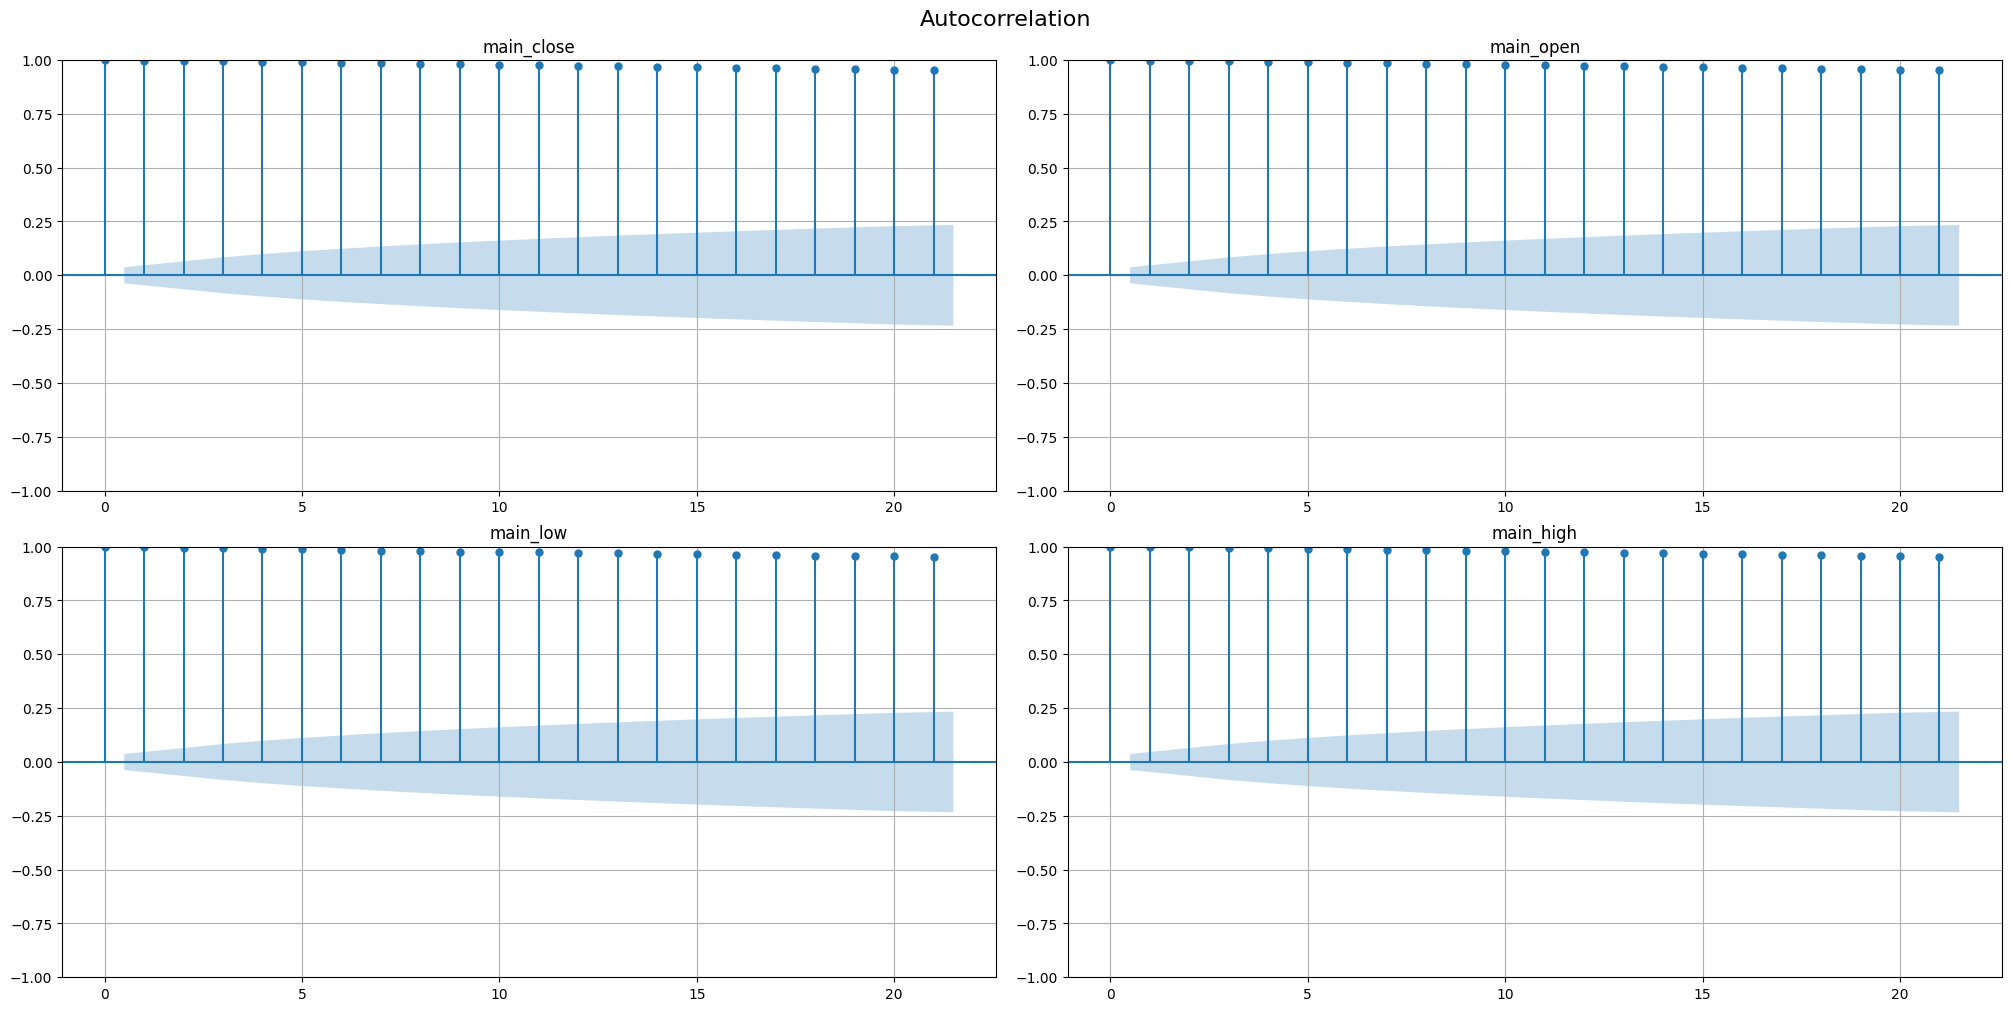

In [ ]:
acf_plot(ts, lags=21)

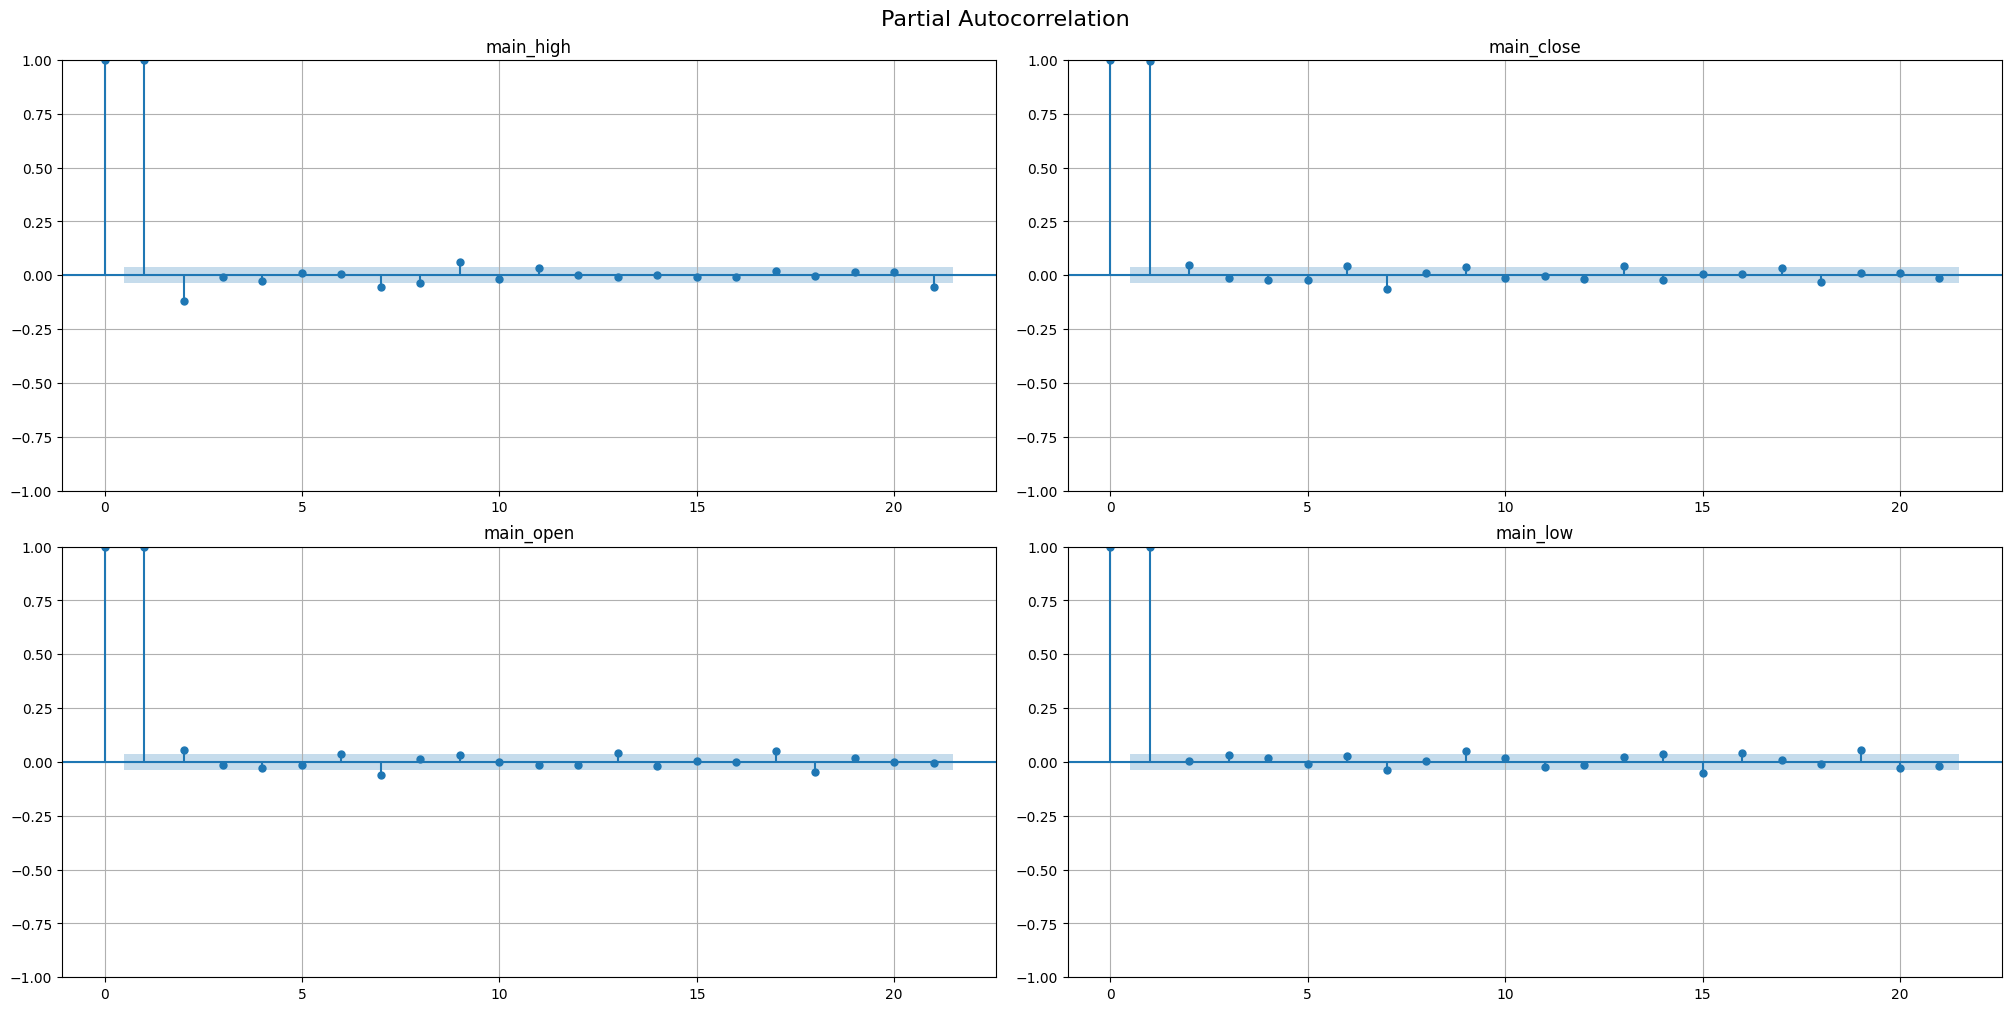

In [ ]:
acf_plot(ts, lags=21, partial=True)

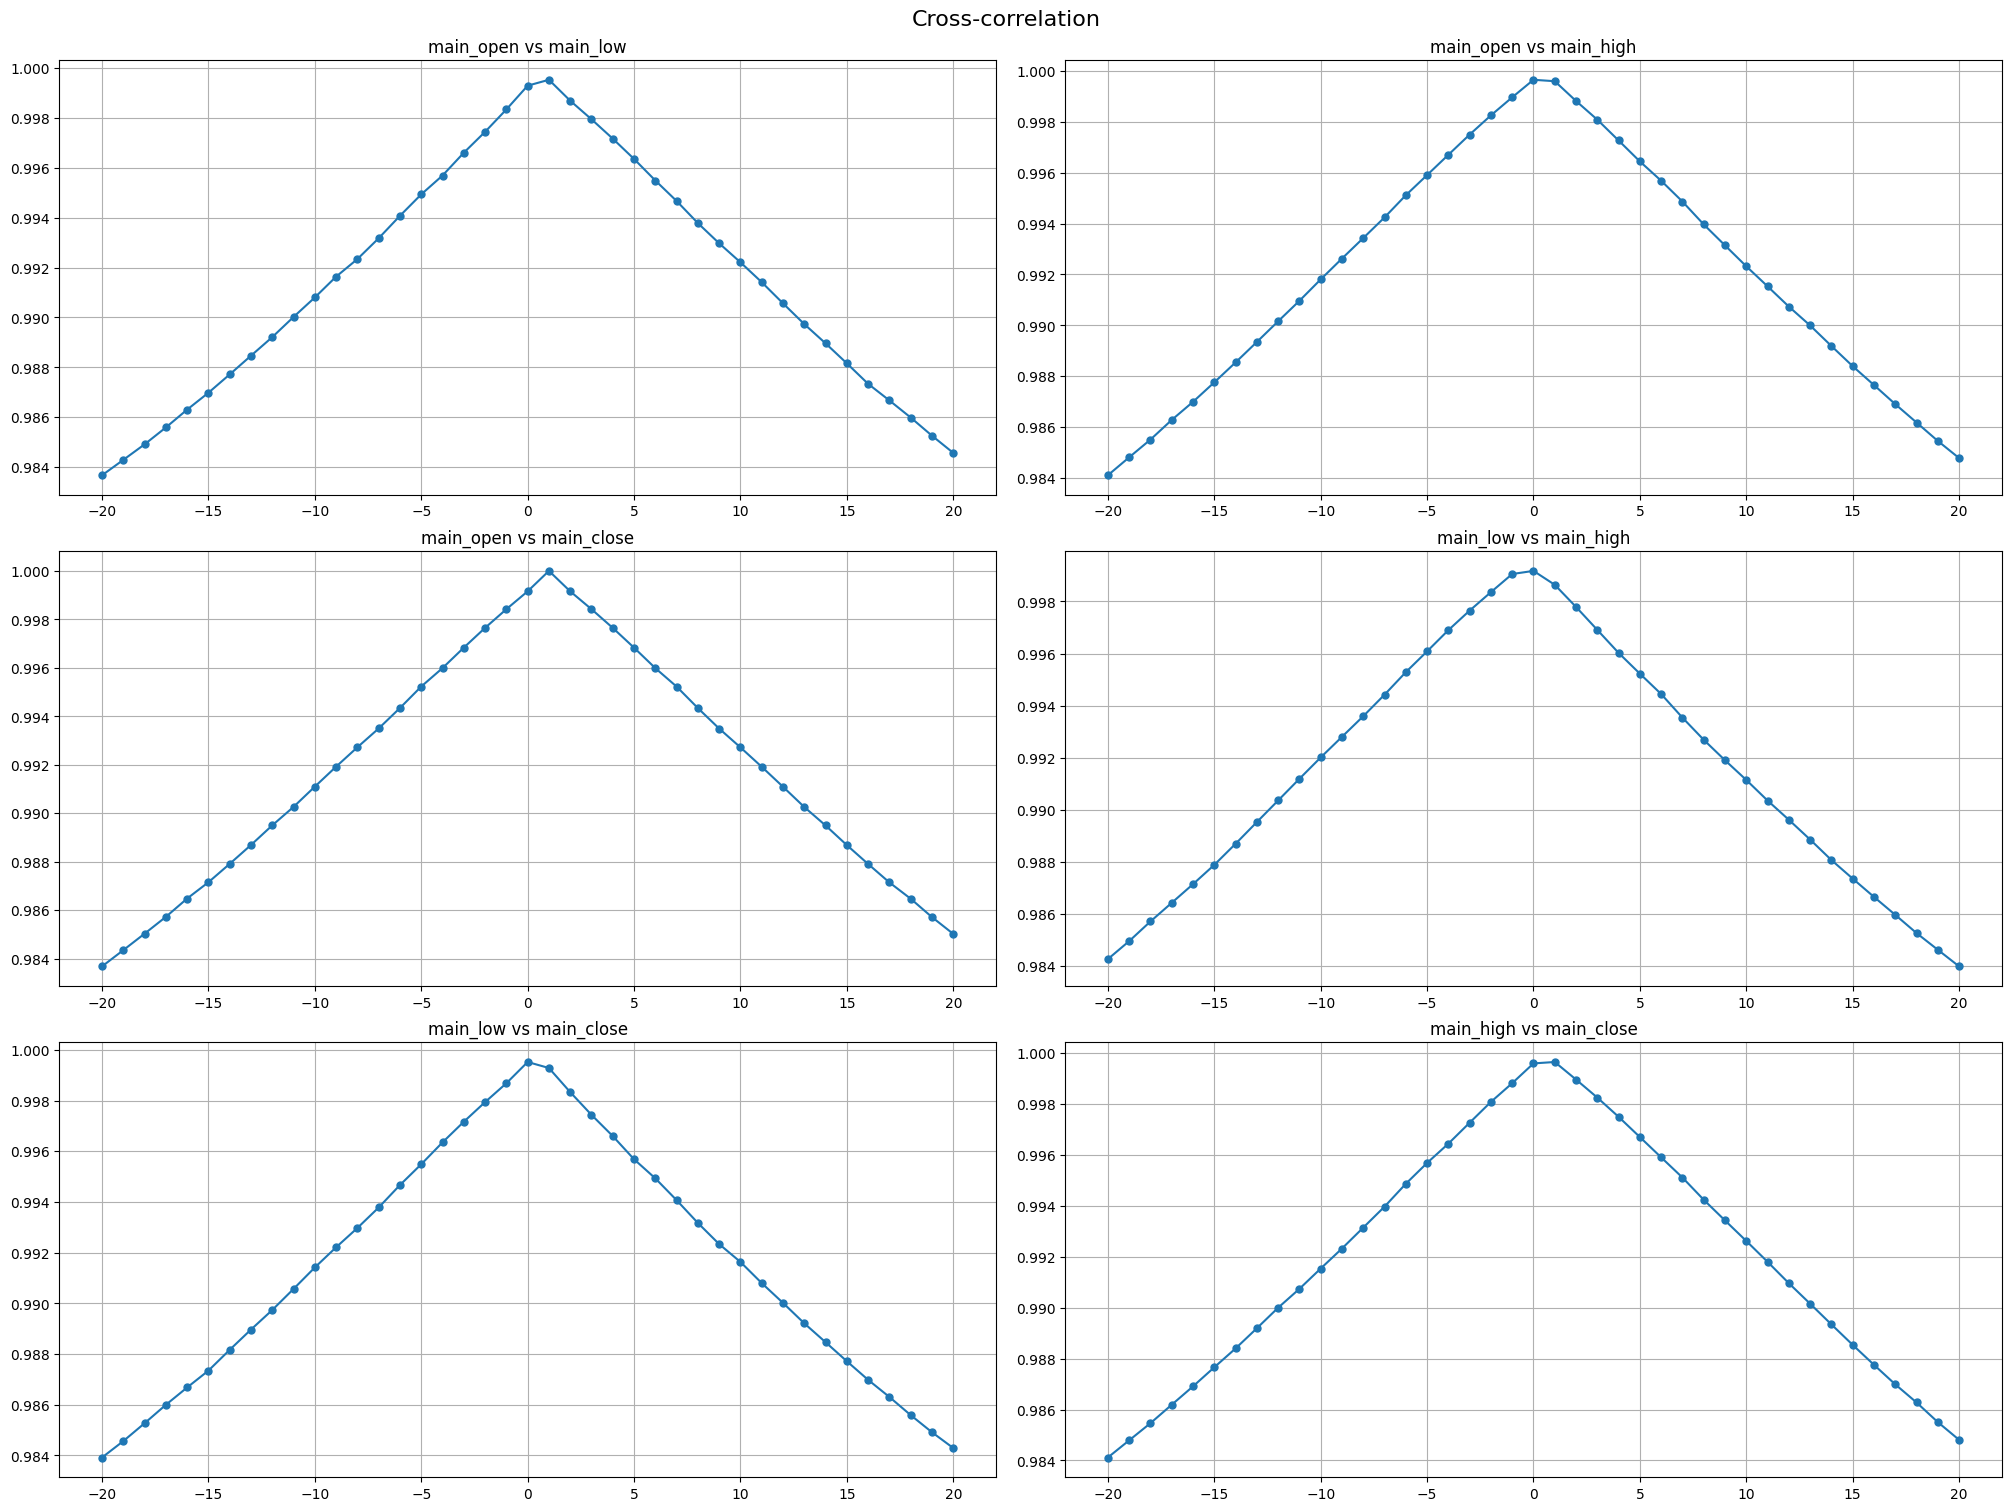

In [ ]:
cross_corr_plot(ts, maxlags=20)

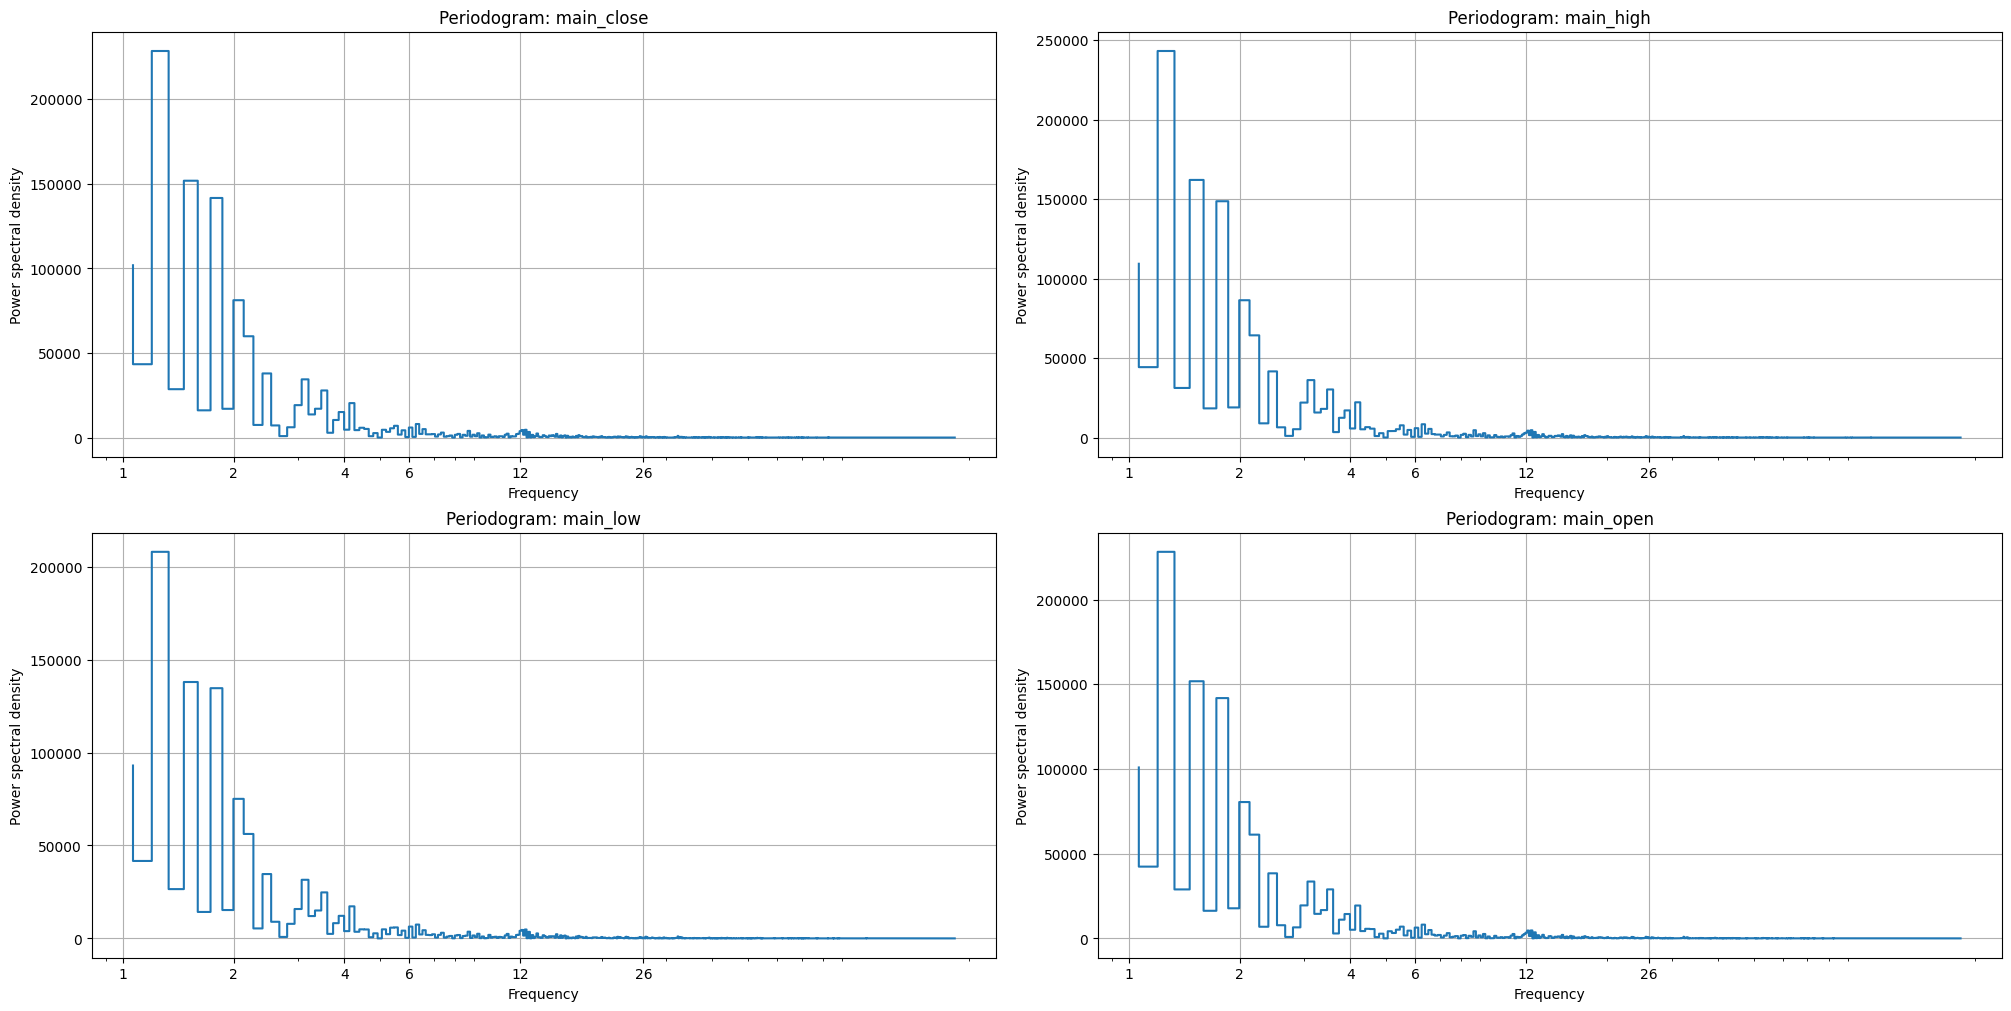

In [ ]:
plot_periodogram(ts, period=365.2425, amplitude_aggregation_mode="per-segment", xticks=[1, 2, 4, 6, 12, 26])

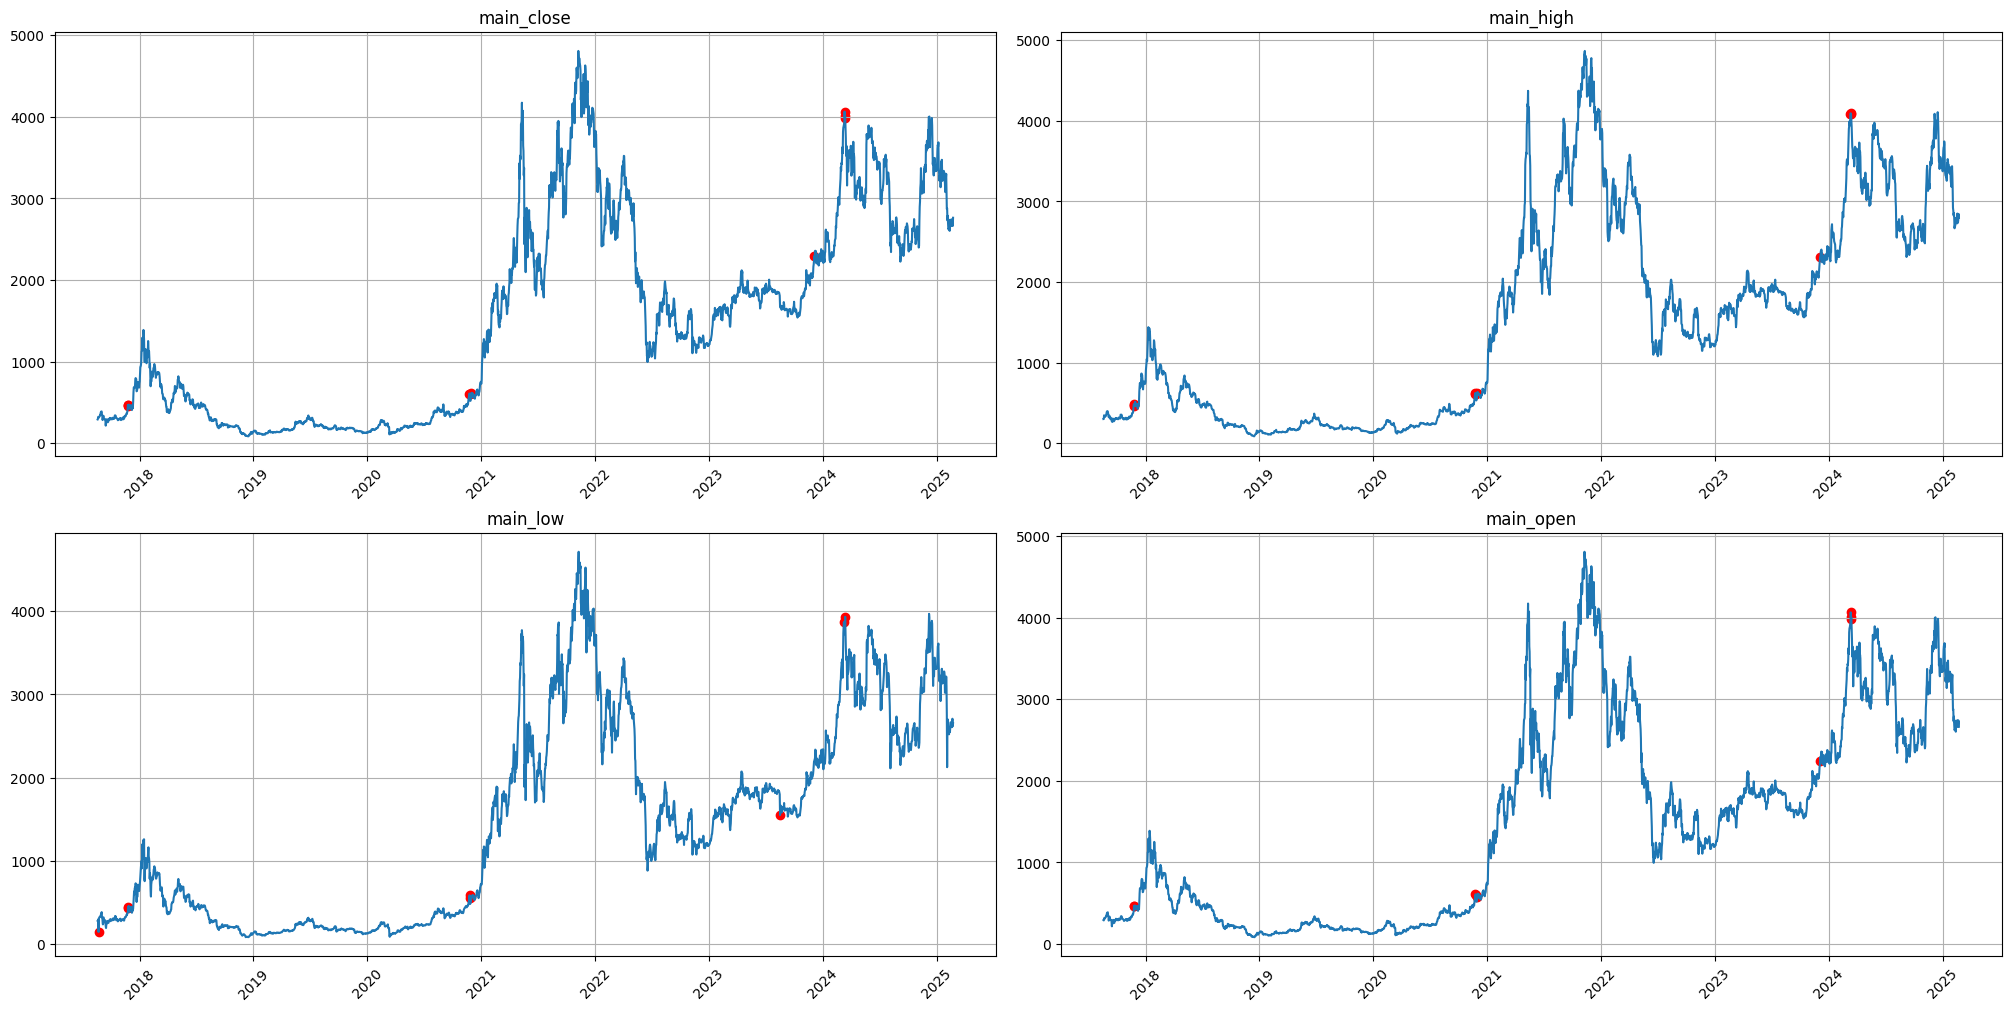

In [ ]:
anomaly_dict = get_anomalies_median(ts, window_size=100)
plot_anomalies(ts, anomaly_dict)

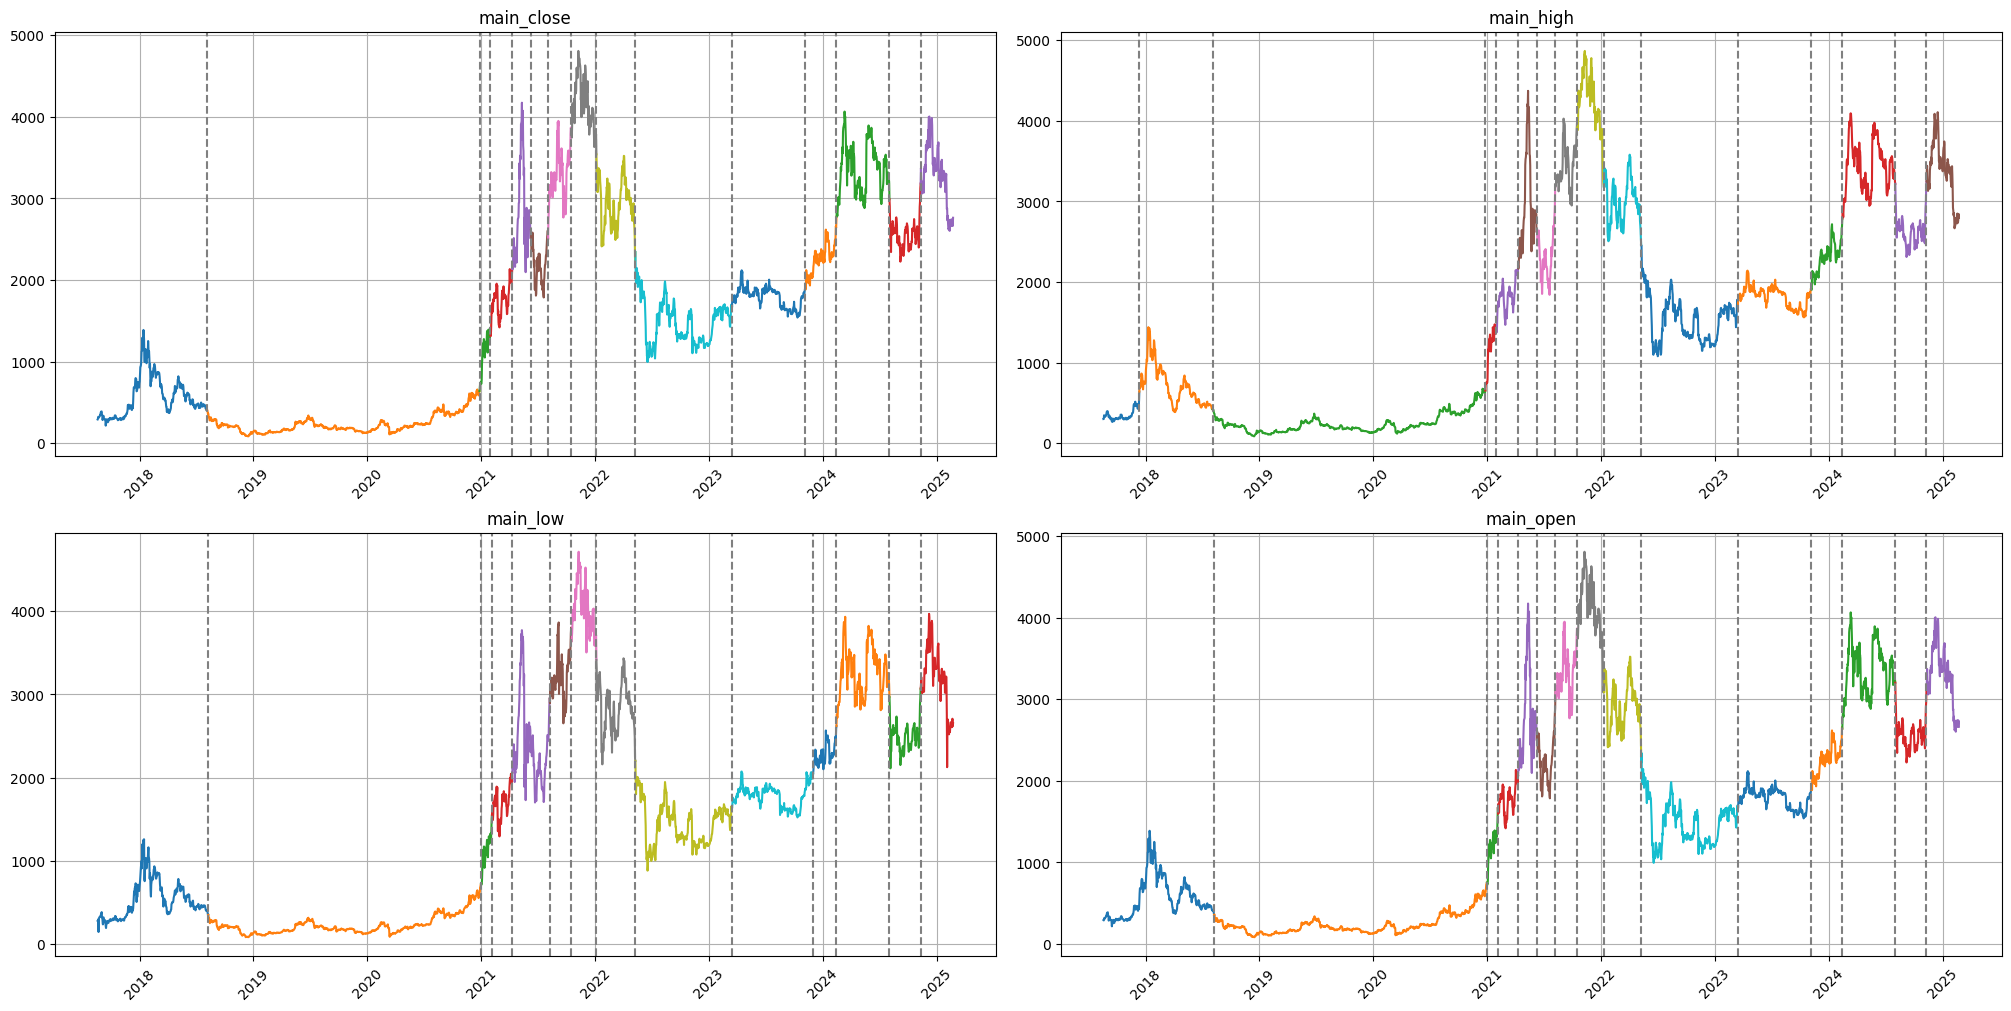

In [ ]:
change_points = find_change_points(ts=ts, in_column="target", change_point_model=Binseg(), pen=1e7)
plot_time_series_with_change_points(ts=ts, change_points=change_points)

In [ ]:
train_ts, test_ts = ts.train_test_split(test_size = 20)

In [ ]:
HORIZON = 20
model = NaiveModel(lag=20)
model.fit(train_ts)

/usr/local/lib/python3.11/dist-packages/etna/models/seasonal_ma.py:64: UserWarning: This model doesn't work with exogenous features. Columns {'low_BTC', 'high_BTC', 'lag_2_low_BTC', 'volume_BTC', 'volume_ETH', 'lag_2_volume_BTC', 'lag_2_close_BTC', 'lag_2_high_BTC', 'open_BTC', 'close_BTC', 'diff_ETH', 'lag_2_diff_ETH', 'lag_2_volume_ETH', 'lag_2_open_BTC'} won't be used.
  warnings.warn(


NaiveModel(lag = 20, )

In [ ]:
future_ts = train_ts.make_future(future_steps=HORIZON, tail_steps=model.context_size)
forecast_ts = model.forecast(future_ts, prediction_size=HORIZON)

In [ ]:
mape = MAPE()

In [ ]:
mape(y_true=test_ts, y_pred=forecast_ts)

{'main_close': 20.298283784600972,
 'main_high': 20.859115166228626,
 'main_low': 21.72564720587246,
 'main_open': 20.572430134347265}

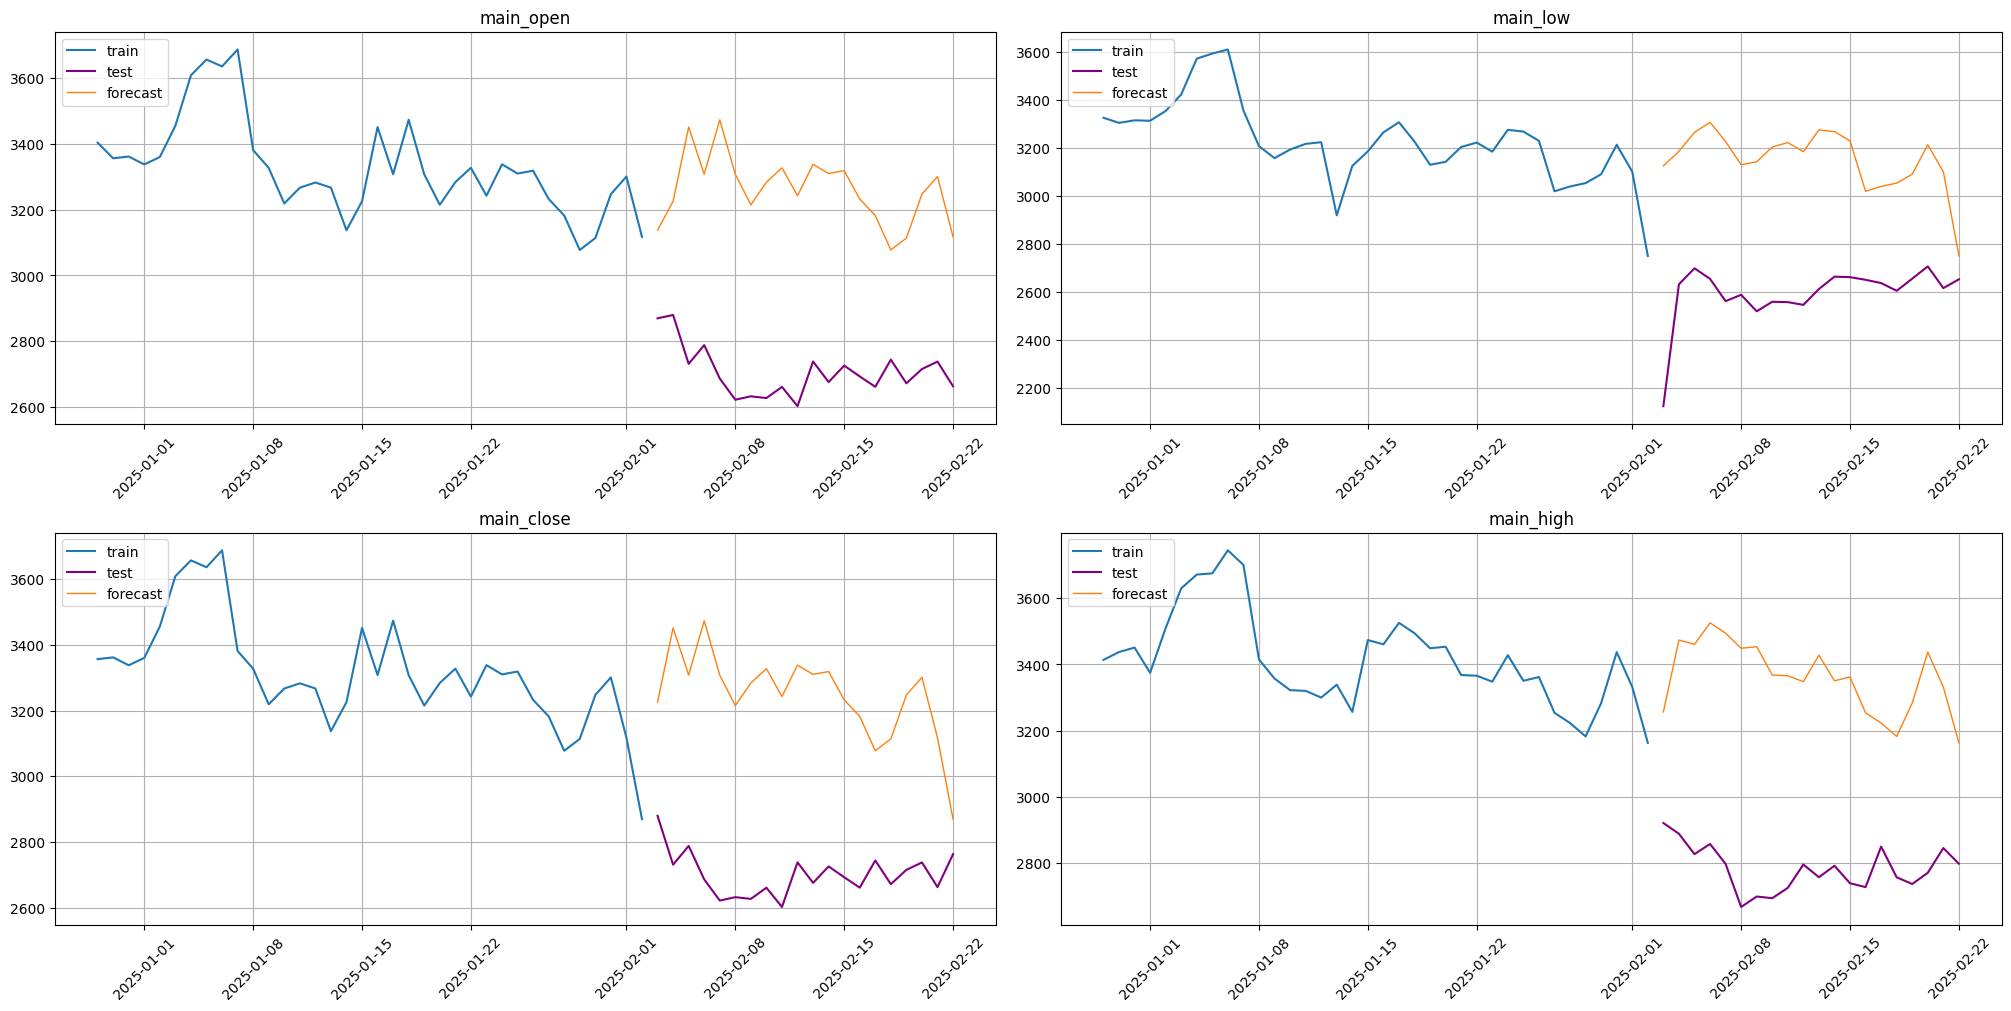

In [ ]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=36)

In [ ]:
ts

segment    main_close                                                    \
feature     close_BTC diff_ETH  high_BTC lag_2_close_BTC lag_2_diff_ETH   
timestamp                                                                 
2017-08-19    4108.37    27.85   4371.52         4285.08          14.18   
2017-08-20    4139.98    21.90   4184.69         4108.37          27.85   
2017-08-21    4086.29    17.68   4211.08         4139.98          21.90   
2017-08-22    4016.00    51.92   4119.62         4086.29          17.68   
2017-08-23    4040.00   186.20   4104.82         4016.00          51.92   
...               ...      ...       ...             ...            ...   
2025-02-18   95780.00   211.99  97046.59        96118.12          76.05   
2025-02-19   95671.74   151.49  96753.91        95780.00         211.99   
2025-02-20   96644.37    80.67  96899.99        95671.74         151.49   
2025-02-21   98305.00    63.41  98711.36        96644.37          80.67   
2025-02-22   96181.98   228.60  99475.00        98305.00          63.41   

segment                                                                  \
feature    lag_2_high_BTC lag_2_low_BTC lag_2_open_BTC lag_2_volume_BTC   
timestamp                                                                 
2017-08-19        4485.39       4200.74        4261.48       795.150377   
2017-08-20        4371.52       3938.77        4285.08      1199.888264   
2017-08-21        4184.69       3850.00        4108.37       381.309763   
2017-08-22        4211.08       4032.62        4120.98       467.083022   
2017-08-23        4119.62       3911.79        4069.13       691.743060   
...                   ...           ...            ...              ...   
2025-02-18       97704.47      96046.18       97569.67      8191.424900   
2025-02-19       97046.59      95205.00       96118.12     16492.045100   
2025-02-20       96753.91      93388.09       95780.01     23368.194710   
2025-02-21       96899.99      95029.99       95671.74     16438.509540   
2025-02-22       98711.36      96415.09       96644.37     17057.391770   

segment                      ...      main_open                               \
feature    lag_2_volume_ETH  ... lag_2_high_BTC lag_2_low_BTC lag_2_open_BTC   
timestamp                    ...                                               
2017-08-19       7030.71034  ...        4485.39       4200.74        4261.48   
2017-08-20       9537.84646  ...        4371.52       3938.77        4285.08   
2017-08-21       2146.19773  ...        4184.69       3850.00        4108.37   
2017-08-22       2510.13871  ...        4211.08       4032.62        4120.98   
2017-08-23       5219.44542  ...        4119.62       3911.79        4069.13   
...                     ...  ...            ...           ...            ...   
2025-02-18     191231.53140  ...       97704.47      96046.18       97569.67   
2025-02-19     639739.81970  ...       97046.59      95205.00       96118.12   
2025-02-20     604863.87370  ...       96753.91      93388.09       95780.01   
2025-02-21     326154.02020  ...       96899.99      95029.99       95671.74   
2025-02-22     336735.25440  ...       98711.36      96415.09       96644.37   

segment                                                                    \
feature    lag_2_volume_BTC lag_2_volume_ETH   low_BTC  open_BTC   target   
timestamp                                                                   
2017-08-19       795.150377       7030.71034   3938.77   4285.08   293.31   
2017-08-20      1199.888264       9537.84646   3850.00   4108.37   289.41   
2017-08-21       381.309763       2146.19773   4032.62   4120.98   299.10   
2017-08-22       467.083022       2510.13871   3911.79   4069.13   321.04   
2017-08-23       691.743060       5219.44542   3400.00   4016.00   312.25   
...                     ...              ...       ...       ...      ...   
2025-02-18      8191.424900     191231.53140  95205.00  96118.12  2744.05   
2025-02

[LogTransform(in_column = 'target', base = 10, inplace = True, out_column = None, ),
 STLTransform(in_column = 'target', period = 7, model = 'arima', robust = True, model_kwargs = None, stl_kwargs = None, ),
 ChangePointsTrendTransform(in_column = 'target', change_points_model = RupturesChangePointsModel(change_points_model = <ruptures.detection.binseg.Binseg object at 0x7b776a776850>, n_bkps = 5, ), per_interval_model = SklearnRegressionPerIntervalModel(model = LinearRegression(), ), ),
 LagTransform(in_column = 'target', lags = [20, 21, 22], out_column = 'lag', ),
 StdTransform(in_column = 'lag_20', window = 7, seasonality = 1, min_periods = 1, fillna = 0, out_column = 'std', ddof = 1, ),
 MeanTransform(in_column = 'lag_20', window = 7, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = 'mean', )]

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   23.6s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   47.7s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  1.2min
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:  1.6min
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:  2.0min
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:  2.4min
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:  2.8min
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:  3.2min
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:  3.6min
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:  4.1min
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:  4.1min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    6.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   10.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:   13.2s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   16.2s
[Parallel(n_jobs=1)]: Do


MAPE_avg (40,)
close:  3.8392240469414247
high:  4.11023927479535
low:  5.624105267906276
open:  3.770034026983692
AVG_metrics:  4.335900654156686


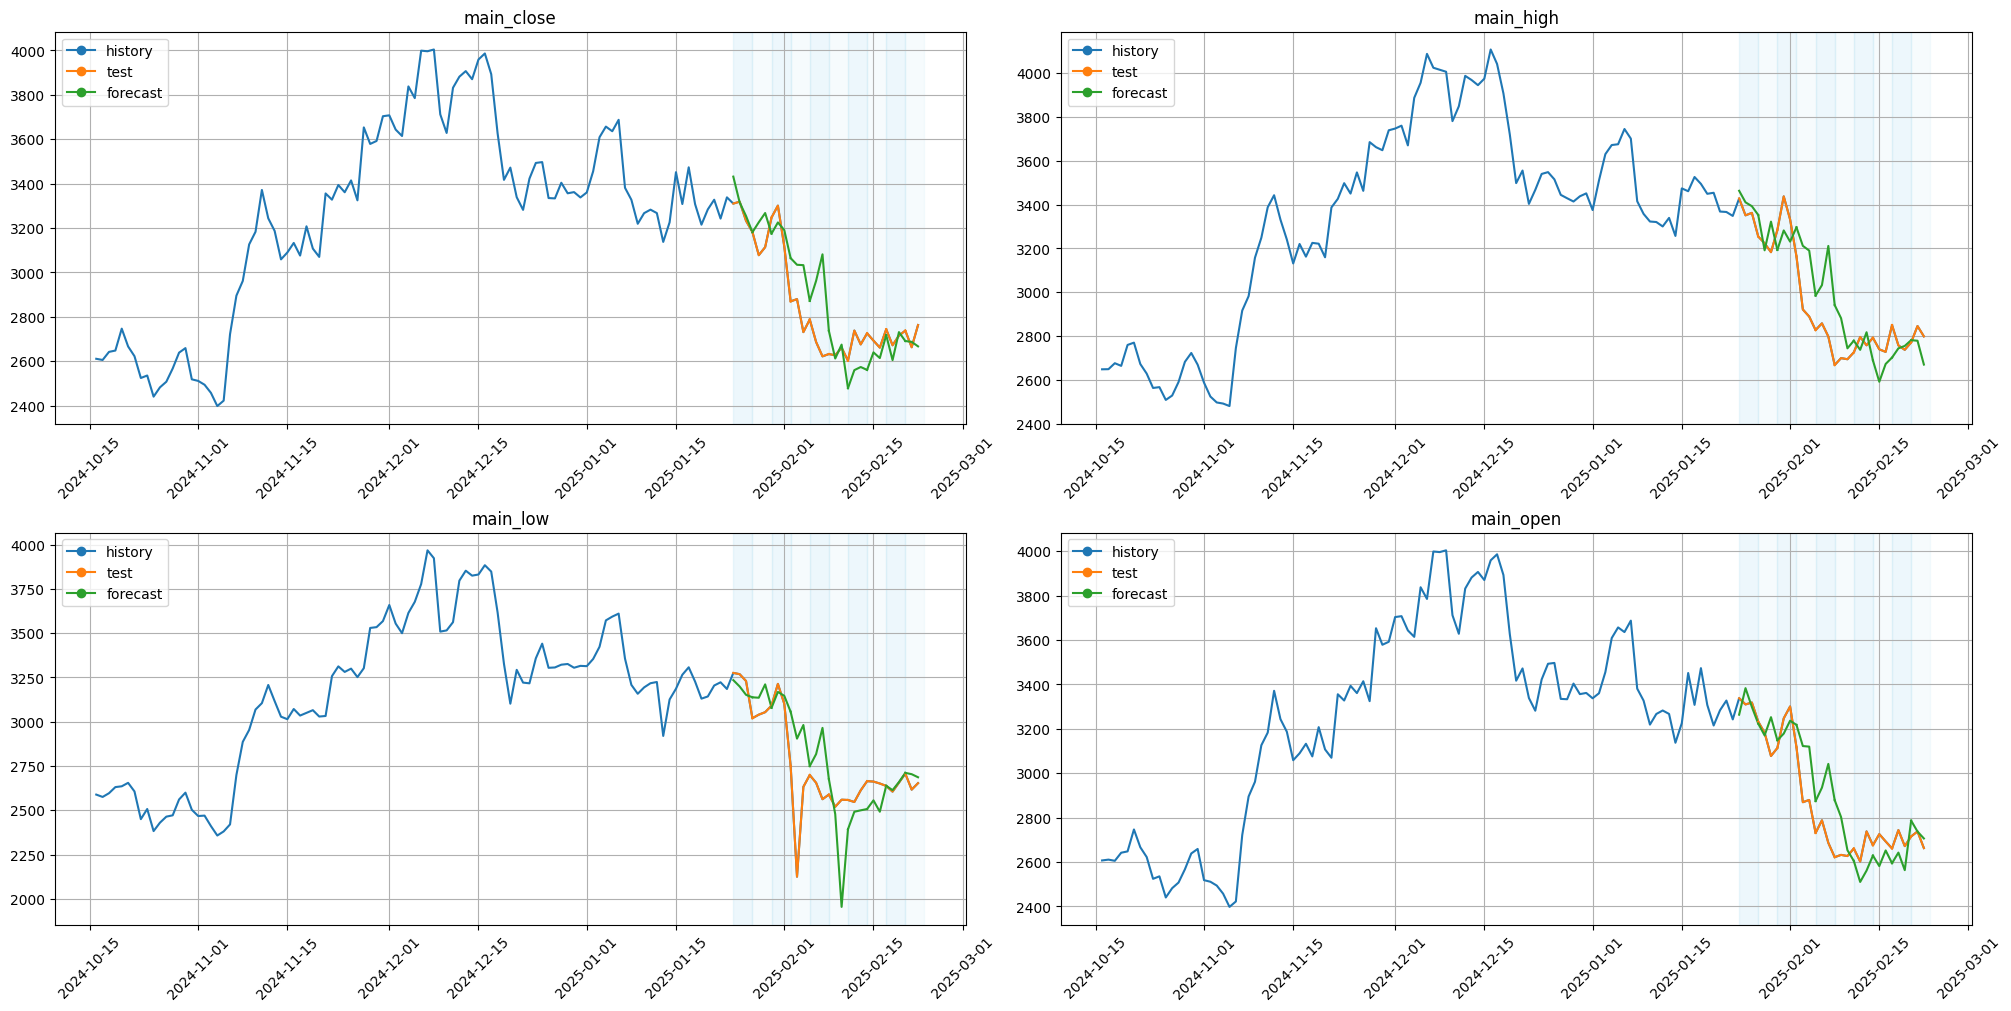

In [ ]:
from etna.transforms import (
    ChangePointsLevelTransform,
    ChangePointsTrendTransform,
    DifferencingTransform,
    LagTransform,
    TheilSenTrendTransform,
    StdTransform,
    MinTransform,
    MaxTransform
)
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

log = LogTransform(in_column="target", inplace=True)
stl = STLTransform(
    in_column = "target",
    period = 7,
    robust = True
)
lags = LagTransform(in_column="target", lags=list(range(HORIZON, 23)), out_column="lag")
mean = MeanTransform(in_column=f"lag_{HORIZON}", window=7, out_column="mean")
std = StdTransform(in_column=f"lag_{HORIZON}", window=7, out_column="std")
CPTI = ChangePointsTrendTransform(in_column="target")
transforms = [log, stl, CPTI, lags, std, mean]
display(transforms)
print()

model = CatBoostMultiSegmentModel(
  iterations=1000,
  learning_rate=0.01,
  depth=8,
  loss_function='MAPE',
  # l2_leaf_reg=2
)
pipeline = Pipeline(model=model, horizon=3, transforms=transforms)
metrics_df, forecast_df, fold_info_df = pipeline.backtest(ts=ts, metrics=[MAE(), MAPE()], n_folds=10)
print()
print('MAPE_avg', metrics_df.MAPE.shape)
print('close: ', metrics_df.MAPE.iloc[:10].mean())
print('high: ', metrics_df.MAPE.iloc[10:20].mean())
print('low: ', metrics_df.MAPE.iloc[20:30].mean())
print('open: ', metrics_df.MAPE.iloc[30:40].mean())
print('AVG_metrics: ', metrics_df.MAPE.mean())

plot_backtest(forecast_df, ts, history_len=100)

[LogTransform(in_column = 'target', base = 10, inplace = True, out_column = None, ),
 STLTransform(in_column = 'target', period = 2, model = 'arima', robust = True, model_kwargs = None, stl_kwargs = None, )]

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  3.4min
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  6.6min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed: 10.0min
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed: 13.4min
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed: 16.6min
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed: 20.0min
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed: 23.3min
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed: 26.7min
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed: 30.1min
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed: 33.4min
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed: 36.8min
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed: 40.1min
[Parallel(n_jobs=1)]: Done  13 tasks      | elapsed: 43.6min
[Parallel(n_jobs=1)]: Done  14 tasks      | elapsed: 47.0min
[Parallel(n_jobs=1)]: Done  15 tasks      | elapsed: 50.3min
[Parallel(n_jobs=1)]: Done  15 tasks      | elapsed: 50.3min
[Parallel(n_jobs=1)]: Do


MAPE_avg (60,)
close:  3.726205539658896
high:  3.7917123582908894
low:  5.187832567135984
open:  3.8173461886294437
AVG_metrics:  4.130774163428803


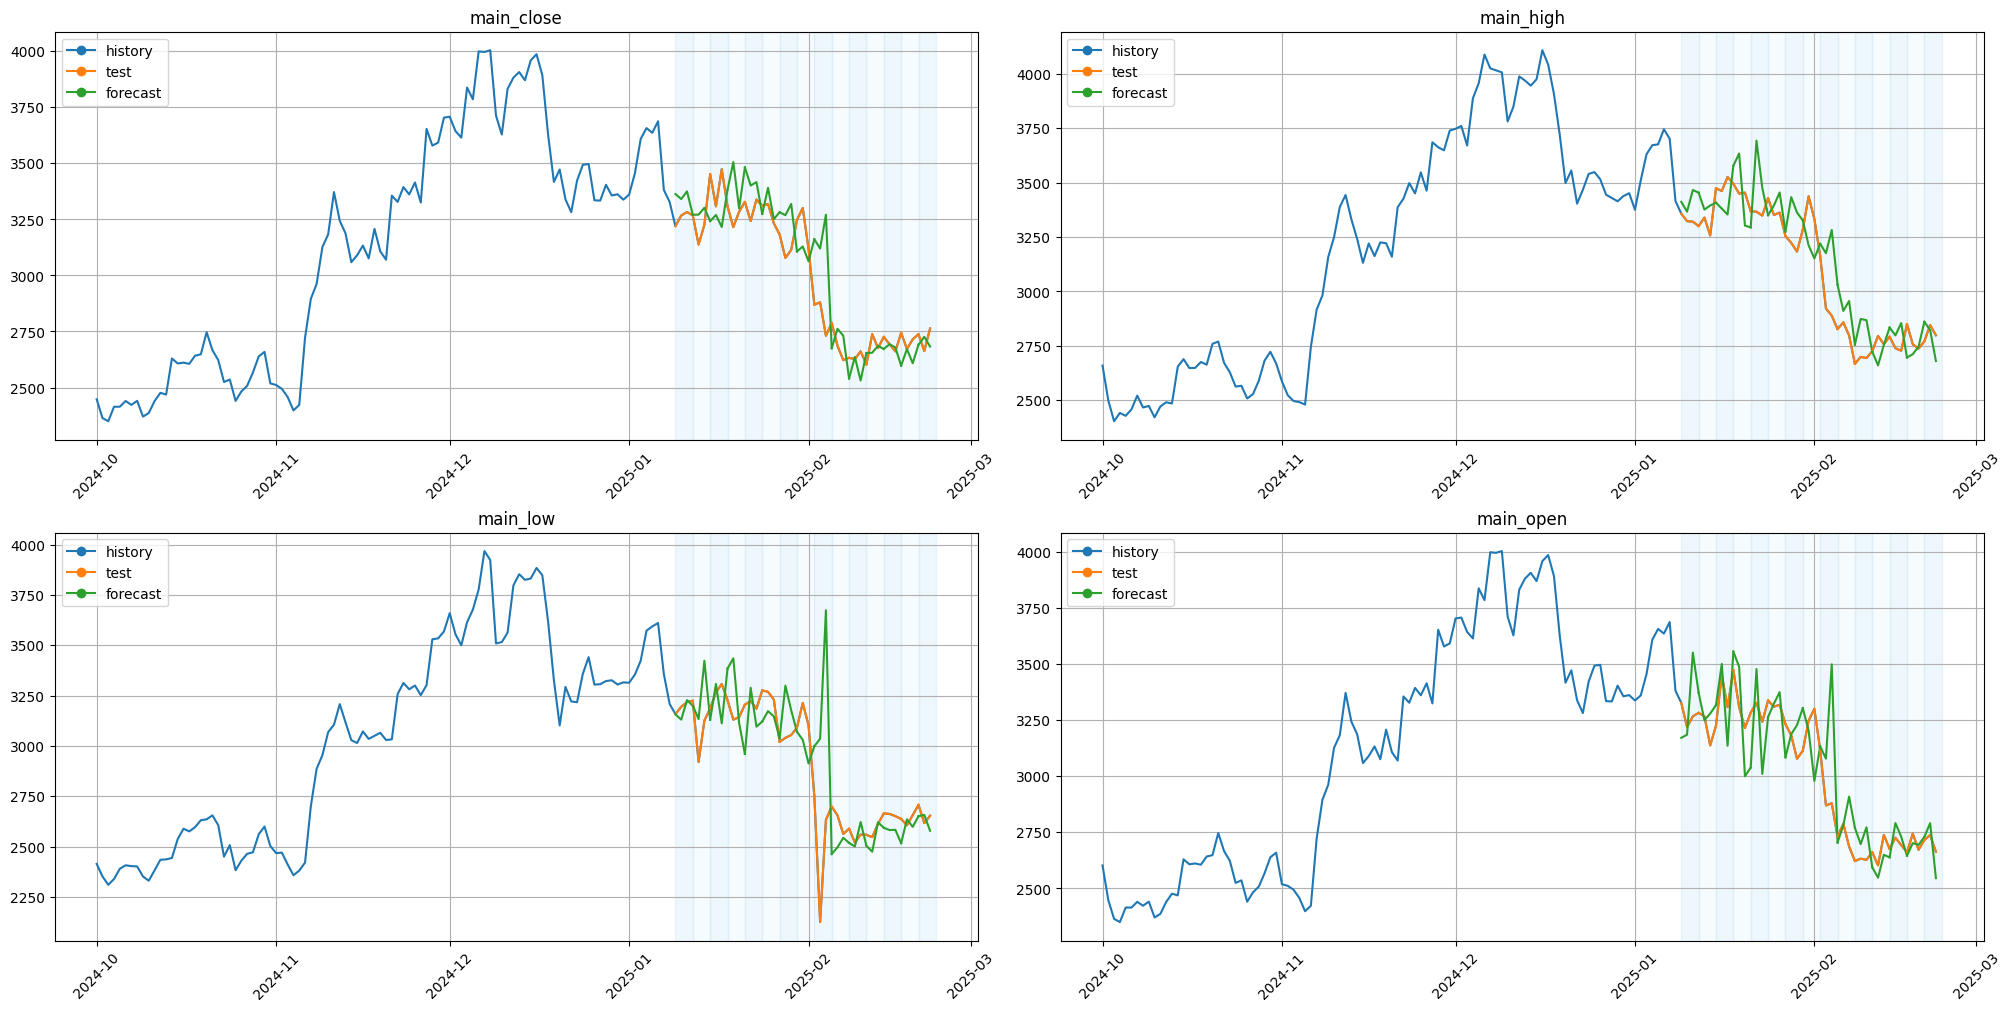

In [ ]:
from etna.models import AutoARIMAModel

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
log = LogTransform(in_column="target", inplace=True)
stl = STLTransform(
    in_column="target",
    period=2,
    robust=True
)
diff = DifferencingTransform(in_column="target", out_column="diff", order=1)
transforms = [log, stl, ]
display(transforms)
print()

model = AutoARIMAModel()

pipeline = Pipeline(model=model, horizon=3, transforms=transforms)
metrics_df, forecast_df, fold_info_df = pipeline.backtest(ts=ts, metrics=[MAE(), MAPE()], n_folds=15)

print()
print('MAPE_avg', metrics_df.MAPE.shape)
print('close: ', metrics_df.MAPE.iloc[:15].mean())
print('high: ', metrics_df.MAPE.iloc[15:30].mean())
print('low: ', metrics_df.MAPE.iloc[30:45].mean())
print('open: ', metrics_df.MAPE.iloc[45:60].mean())
print('AVG_metrics: ', metrics_df.MAPE.mean())

plot_backtest(forecast_df, ts, history_len=100)

In [ ]:
model.get_model()